# Predicción de riesgo de abandono en un Programa de Salud Mental
*Matías Fernández*

*Diplomado IA aplicada en Salud, UTFSM*

*https://github.com/PSIMAFG/Entrega_ML_Corregida* Acceso a datos 


## 2. Objetivo

**Propósito.** Desarrollar y validar un **modelo de clasificación binaria** que estime la probabilidad de **abandono (1)** vs **alta (0)** al egreso, utilizando `BDEGRESO.xlsx` (datos simulados que replican la base original; egresos 2020–2023). El flujo contempla **preprocesamiento reproducible**, **comparación de algoritmos** y **ajuste del umbral de decisión** post-entrenamiento para optimizar el desempeño.

**Tarea.** Clasificación binaria en **muestra desbalanceada**  
(*target*: `Y_ABANDONO` con mapeo `1=abandono`, `0=alta`).

**Datos utilizados.**
- Variables demográficas/administrativas y derivadas de tiempo:
  - `SEXO`, `GRUPO_ETARIO_MIN`, `HUBO_RESCATE`, `PERMANENCIA_DIAS`, `DIAS_ULT_ATENCION_A_RESCATE`
  - Dummies de diagnóstico `DX_*` y de profesional `PROF_*`

**Algoritmos evaluados.**
- **GPU:** XGBoost, LightGBM, CatBoost
- **CPU:** Random Forest, Regresión Logística, SVM

**Validación y selección.**
- **Validación cruzada estratificada**
- Selección por **Balanced Accuracy (BA)** y **MCC**
- **Ajuste de umbral** para priorizar:
  - **Sensibilidad (TPR) para Abandono ≥ 0.90**
  - **Especificidad (TNR) para Altas ≥ 0.50**  
  *(en la medida que lo permita el comportamiento inicial del dataset)*

> **Nota:** BA = (TPR + TNR) / 2. En datos desbalanceados, BA y MCC entregan señales más estables que la exactitud global.

**Resultado esperado.**
- Escoger el **modelo + umbral** que mejor cumpla las metas
- Documentar métricas: **ROC-AUC**, **PR-AUC**, **precisión**, **recall**, **BA**, **MCC**
- Dejar un **artefacto de inferencia** listo para aplicar a nuevas listas de pacientes (pipeline y umbral fijado)


## 3. Introducción

### a) Contexto
El Programa de Salud Mental registra egresos por **alta** o **abandono**. Anticipar el riesgo de abandono permite **priorizar acciones de rescate** y de **gestión clínica** para prevenirlo. La base `BDEGRESO.xlsx` (datos simulados basados en 2020–2023) contiene variables administrativas y clínicas (p. ej., `SEXO`, `GRUPO_ETARIO_MIN`, diagnósticos, tipo de profesional de última atención) y **fechas clave** (ingreso, egreso, última atención, rescate), a partir de las cuales derivamos **indicadores temporales** asociados a la permanencia en el programa.  
El principal reto es el **desbalance de clases** (**abandono ≈ 80%**, **alta ≈ 20%**) y el **tamaño muestral moderado**.

### b) Objetivo del modelo
Construir un **clasificador binario** que estime la probabilidad de **abandono (1)** vs **alta (0)** al egreso, **maximizando la detección de abandonos** sin penalizar en exceso las **altas** (clase minoritaria). Operativamente, el **ajuste de umbral** buscará cumplir:

- **Sensibilidad (TPR) para Abandono ≥ 0.90**  *(≥ 90% de abandonos reconocidos)*  
- **Especificidad (TNR) para Altas ≥ 0.50**  *(≥ 50% de altas correctamente identificadas)*  
*(cuando sea factible según los datos).*

Esta medida se adoptó porque en pruebas iniciales se observó **overfitting** hacia la clase *abandono*, con un número elevado de **falsos positivos** que diluía la utilidad de la alerta. Por ello se buscó el **mejor equilibrio** posible entre **falsos negativos** y **falsos positivos** según distintas métricas.

**Para robustez:**
- Se comparan rendimientos de **Random Forest**, **XGBoost (GPU)**, **LightGBM (GPU)**, **CatBoost (GPU)**, **Regresión Logística** y **SVM**.  
- Se emplea **validación cruzada estratificada** y **tuning de umbral por *fold***.  
- Las métricas foco son **Balanced Accuracy (BA)** y **MCC**, junto a **ROC-AUC** y **PR-AUC**.

### c) Alcance del reporte
El análisis cubre:

- **Preprocesamiento de datos:** limpieza, normalización de textos, codificación categórica (dummies `DX_*`, `PROF_*`), derivación de `PERMANENCIA_DIAS` y `DIAS_ULT_ATENCION_A_RESCATE` a partir de fechas, y **controles de calidad** (p. ej., permanencia negativa).  
- **Definición del *target*** desde `OBS._ESTADISTICAS` (**alta vs abandono**) y **manejo del desbalance** (ponderación de clases y/o ajuste de umbral).  
- **Comparación de modelos** con **validación cruzada** (GPU donde aplique), incluyendo **ajuste de umbral guiado por metas** y **resumen de métricas**.  
- **Selección del modelo/umbral** basada en **BA** y **MCC** con rendimientos esperados; **reporte de importancias/coeficientes** para su interpretación.  
- **Pipeline de inferencia:** alineación de columnas, transformaciones necesarias (**Yeo-Johnson + estandarización** para modelos lineales como RL).
- **Limitaciones y riesgos:** tamaño muestral, estabilidad de métricas en la clase minoritaria (altas), potenciales sesgos y pasos propuestos para mejora futura (nuevas *features* temporales y de adherencia).


In [2]:
#Importo librerias
from pathlib import Path

import re
import unicodedata

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from scipy.stats import shapiro, skew, kurtosis

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
pd.set_option("display.max_columns", 50)

#Dataset
DATA_PATH = Path("BDEGRESO.xlsx")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"No se encontró el archivo {DATA_PATH.resolve()}.")

df = pd.read_excel(DATA_PATH)

print(f"Dimensiones del dataset: {df.shape}")
display(df.head())

print("Tipos de datos:")
display(df.dtypes.to_frame(name="dtype"))

print("Conteo de valores únicos por columna:")
display(df.nunique().sort_values(ascending=False))

#Exploración inicial

aux_nulos = (
    df.isna().sum().to_frame(name="nulos")
      .assign(pct=lambda s: (s["nulos"] / len(df)).round(3))
)

print("\nValores nulos por columna:")
display(aux_nulos)

num_duplicadas = df.duplicated().sum()
print(f"¿Existen filas duplicadas?: {bool(num_duplicadas)}")
print(f"Número de filas duplicadas: {num_duplicadas}")

Dimensiones del dataset: (445, 11)


,N,CODIGO,SEXO,GRUPO ETARIO,DIAGNÓSTICO,FECHA DE INGRESO,FECHA DE EGRESO,OBS. ESTADÍSTICAS,FECHA ÚLTIMA ATENCIÓN SM,PROFESIONAL ÚLTIMA ATENCIÓN,FECHA ÚLTIMO RESCATE
0,1,9FB0422F7268,M,10-14 años,Otros Trastornos de Ansiedad,2021-11-17,2023-03-30,ALTA CLÍNICA,2023-03-24,T. Social,NaN
1,2,F61C48FE6719,M,35-39 años,Consumo de Drogas y Alcohol,2021-08-24,2023-10-05,ABANDONO,2021-09-03,T. Social,NaN
2,3,A3437E83BEFA,F,80 y más años,Demencia Avanzada,2020-12-15,2023-10-05,FALLECIMIENTO,2022-09-13,Médico,NaN
3,4,91BC134F4319,M,60-64 años,Otros Trastornos de Ansiedad,2022-04-22,2023-10-10,ABANDONO,2022-04-25,Psicólogo/a,NaN
4,5,476040A720E6,M,75-79 años,Depresión Leve,2022-08-24,2023-10-23,ALTA CLÍNICA,2023-10-23,Psicólogo/a,NaN


Tipos de datos:


,dtype
N,int64
CODIGO,object
SEXO,object
GRUPO ETARIO,object
DIAGNÓSTICO,object
FECHA DE INGRESO,datetime64[ns]
FECHA DE EGRESO,datetime64[ns]
OBS. ESTADÍSTICAS,object
FECHA ÚLTIMA ATENCIÓN SM,datetime64[ns]
PROFESIONAL ÚLTIMA ATENCIÓN,object


Conteo de valores únicos por columna:


N                               445
CODIGO                          445
FECHA DE INGRESO                375
FECHA ÚLTIMA ATENCIÓN SM        317
FECHA DE EGRESO                 188
FECHA ÚLTIMO RESCATE             88
OBS. ESTADÍSTICAS                25
DIAGNÓSTICO                      24
GRUPO ETARIO                     16
PROFESIONAL ÚLTIMA ATENCIÓN       5
SEXO                              2
dtype: int64


Valores nulos por columna:


,nulos,pct
N,0,0.000
CODIGO,0,0.000
SEXO,2,0.004
GRUPO ETARIO,2,0.004
DIAGNÓSTICO,9,0.020
FECHA DE INGRESO,14,0.031
FECHA DE EGRESO,5,0.011
OBS. ESTADÍSTICAS,2,0.004
FECHA ÚLTIMA ATENCIÓN SM,58,0.130
PROFESIONAL ÚLTIMA ATENCIÓN,58,0.130


¿Existen filas duplicadas?: False
Número de filas duplicadas: 0


Comentario (resumen del bloque anterior): prepara el entorno de análisis y visualización, carga BDEGRESO.xlsx (fallando explícitamente si no existe) y hace un pantallazo del dataset (dimensiones, primeras filas, tipos y cardinalidad). Además ejecuta revisiones básicas de calidad de datos: nulos por columna y filas duplicadas.

### Preprocesamiento
- **Estandarización de nombres:** limpieza, tildes → ASCII, mayúsculas, `_` como separador.
- **Depuración:** eliminación de identificadores (`N`, `CODIGO`), tratamiento básico de nulos; categóricas faltantes a etiquetas explícitas (p. ej., `DIAGNOSTICO="DX404"`).
- **Fechas a `datetime`** y **derivadas sin fuga de información**:
  - `PERMANENCIA_DIAS = FECHA_ULTIMA_ATENCION_SM − FECHA_DE_INGRESO`.
  - `DIAS_ULT_ATENCION_A_RESCATE = FECHA_ULTIMO_RESCATE − FECHA_ULTIMA_ATENCION_SM` (permite `NaN` si no hubo rescate) y flag **`HUBO_RESCATE`**.
- **Codificación categórica:** one-hot para `DIAGNOSTICO` (`DX_*`) y `PROFESIONAL_ULTIMA_ATENCION` (`PROF_*`); `SEXO` mapeado a 0/1; `GRUPO_ETARIO_MIN` como ordinal (límite inferior).
- **Higiene y control de calidad:** recorte de duraciones **negativas** a `NaN` con aviso; chequeo de columnas constantes; mantenimiento de `NaN` para imputación posterior en modelos que lo requieran (lineales/SVM).

In [3]:
# PREPROCESAMIENTO (Leakage corregido=

# Copia de trabajo
df_clean = df.copy()

# Normalizar nombres de columnas
def normalize_col(s: str) -> str:
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.upper().replace(" ", "_")
    return s

original_cols = df_clean.columns.tolist()
df_clean.columns = [normalize_col(c) for c in df_clean.columns]

print("\n=== Renombre de columnas (original -> normalizado) ===")
for k, v in zip(original_cols, df_clean.columns.tolist()):
    if k != v:
        print(f"  {k!r} -> {v!r}")

# Eliminar identificadores irrelevantes
cols_to_drop = [c for c in ["N", "CODIGO"] if c in df_clean.columns]
df_clean.drop(columns=cols_to_drop, inplace=True, errors="ignore")
if cols_to_drop:
    print("\nColumnas eliminadas:", cols_to_drop)


# Tratamiento de nulos
if "PROFESIONAL_ULTIMA_ATENCION" in df_clean.columns:
    df_clean["PROFESIONAL_ULTIMA_ATENCION"] = df_clean["PROFESIONAL_ULTIMA_ATENCION"].fillna("NN")

if "FECHA_ULTIMO_RESCATE" in df_clean.columns:
    df_clean["FECHA_ULTIMO_RESCATE_TXT"] = df_clean["FECHA_ULTIMO_RESCATE"].fillna("Sin registrar").astype(str)
    df_clean["HUBO_RESCATE"] = df_clean["FECHA_ULTIMO_RESCATE"].notna().astype(int)
else:
    df_clean["HUBO_RESCATE"] = 0


# Fechas a datetime
for col in ["FECHA_DE_INGRESO", "FECHA_DE_EGRESO", "FECHA_ULTIMA_ATENCION_SM", "FECHA_ULTIMO_RESCATE"]:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col], errors="coerce")


# Variables derivadas de fechas (SIN USAR FECHA_DE_EGRESO)
def _clip_negatives(series: pd.Series, name: str) -> pd.Series:
    """Convierte duraciones negativas en NaN y avisa cuántas se corrigen."""
    neg = (series < 0).sum()
    if neg > 0:
        print(f"[AVISO] {name}: {neg} valores negativos -> NaN (revisar calidad de fechas).")
    return series.mask(series < 0)

# 1) Permanencia: última atención - ingreso
df_clean["PERMANENCIA_DIAS"] = (
    df_clean["FECHA_ULTIMA_ATENCION_SM"] - df_clean["FECHA_DE_INGRESO"]
).dt.days
df_clean["PERMANENCIA_DIAS"] = _clip_negatives(df_clean["PERMANENCIA_DIAS"], "PERMANENCIA_DIAS")

# 2) Tiempo entre última atención y rescate (si hubo rescate)
df_clean["DIAS_ULT_ATENCION_A_RESCATE"] = (
    df_clean["FECHA_ULTIMO_RESCATE"] - df_clean["FECHA_ULTIMA_ATENCION_SM"]
).dt.days
df_clean["DIAS_ULT_ATENCION_A_RESCATE"] = _clip_negatives(
    df_clean["DIAS_ULT_ATENCION_A_RESCATE"], "DIAS_ULT_ATENCION_A_RESCATE"
)


# Codificación de categóricas
# SEXO → 0/1
if "SEXO" in df_clean.columns:
    df_clean["SEXO"] = (
        df_clean["SEXO"].astype(str).str.strip().str.upper().map({"M": 0, "F": 1})
    )

# GRUPO_ETARIO → valor ordinal (límite inferior)
def lower_bound_age(texto: str) -> float:
    if not isinstance(texto, str):
        return np.nan
    m = re.search(r"\d+", texto)
    return float(m.group()) if m else np.nan

if "GRUPO_ETARIO" in df_clean.columns:
    df_clean["GRUPO_ETARIO_MIN"] = df_clean["GRUPO_ETARIO"].astype(str).map(lower_bound_age)

# Diagnósticos nulos → DX404 (desconocido)
if "DIAGNOSTICO" in df_clean.columns:
    missing_dx = df_clean["DIAGNOSTICO"].isna().sum()
    if missing_dx > 0:
        print(f"\nSe reemplazaron {missing_dx} diagnósticos nulos por 'DX404'")
    df_clean["DIAGNOSTICO"] = df_clean["DIAGNOSTICO"].fillna("DX404")

# One-hot para diagnósticos y profesionales
dummies_parts = []
if "DIAGNOSTICO" in df_clean.columns:
    dummies_parts.append(
        pd.get_dummies(
            df_clean["DIAGNOSTICO"].astype(str).str.strip(),
            prefix="DX",
            drop_first=True,
        )
    )
if "PROFESIONAL_ULTIMA_ATENCION" in df_clean.columns:
    dummies_parts.append(
        pd.get_dummies(
            df_clean["PROFESIONAL_ULTIMA_ATENCION"].astype(str).str.strip(),
            prefix="PROF",
            drop_first=True,
        )
    )
if dummies_parts:
    df_clean = pd.concat([df_clean] + dummies_parts, axis=1)


# Target a partir de OBS._ESTADISTICAS

def map_target(val: str) -> str:
    val = val.upper()
    if "ALTA" in val or "RECUPERADO" in val:
        return "ALTA"
    if "ABANDONO" in val or "ANANDONO" in val or "ADMINISTRATIVO" in val:
        return "ABANDONO"
    return "OTROS"

if "OBS._ESTADISTICAS" not in df_clean.columns:
    raise KeyError("No se encontró la columna 'OBS._ESTADISTICAS' en el dataset.")

print("\n=== Distribución original de OBS._ESTADISTICAS ===")
print(df_clean["OBS._ESTADISTICAS"].value_counts(dropna=False).head(15))

obs_norm = df_clean["OBS._ESTADISTICAS"].astype(str).map(map_target)
mask_valid = obs_norm.isin(["ALTA", "ABANDONO"])
df_clean = df_clean[mask_valid].copy()
df_clean["Y_ABANDONO"] = (obs_norm[mask_valid] == "ABANDONO").astype(int)

print("\n=== Distribución recodificada del target ===")
print(df_clean["Y_ABANDONO"].value_counts().rename({0: "Alta", 1: "Abandono"}))


# Filtrado final 
# - Requerimos PERMANENCIA_DIAS válido.
# - Permitimos NaN en DIAS_ULT_ATENCION_A_RESCATE (si no hubo rescate).

before_rows = df_clean.shape[0]
df_clean = df_clean.dropna(subset=["PERMANENCIA_DIAS"])
removed_rows = before_rows - df_clean.shape[0]
if removed_rows > 0:
    print(f"\nSe eliminaron {removed_rows} filas sin PERMANENCIA_DIAS (fechas inválidas de ingreso/última atención).")

if "HUBO_RESCATE" in df_clean.columns:
    pct_no_rescate = (df_clean["HUBO_RESCATE"] == 0).mean() * 100
    print(f"[INFO] Registros sin rescate: {pct_no_rescate:.1f}% (DIAS_ULT_ATENCION_A_RESCATE = NaN).")

# vista rápida de columnas generadas
cols_preview = ["SEXO", "GRUPO_ETARIO", "GRUPO_ETARIO_MIN", "HUBO_RESCATE",
                "PERMANENCIA_DIAS", "DIAS_ULT_ATENCION_A_RESCATE", "Y_ABANDONO"]
print("\n=== Vista rápida de columnas clave (si existen) ===")
print([c for c in cols_preview if c in df_clean.columns])



=== Renombre de columnas (original -> normalizado) ===
  'SEXO ' -> 'SEXO'
  'GRUPO ETARIO' -> 'GRUPO_ETARIO'
  'DIAGNÓSTICO' -> 'DIAGNOSTICO'
  'FECHA DE INGRESO ' -> 'FECHA_DE_INGRESO'
  'FECHA DE EGRESO' -> 'FECHA_DE_EGRESO'
  'OBS. ESTADÍSTICAS ' -> 'OBS._ESTADISTICAS'
  'FECHA ÚLTIMA ATENCIÓN SM ' -> 'FECHA_ULTIMA_ATENCION_SM'
  'PROFESIONAL ÚLTIMA ATENCIÓN ' -> 'PROFESIONAL_ULTIMA_ATENCION'
  'FECHA ÚLTIMO RESCATE' -> 'FECHA_ULTIMO_RESCATE'

Columnas eliminadas: ['N', 'CODIGO']
[AVISO] PERMANENCIA_DIAS: 15 valores negativos -> NaN (revisar calidad de fechas).
[AVISO] DIAS_ULT_ATENCION_A_RESCATE: 2 valores negativos -> NaN (revisar calidad de fechas).

Se reemplazaron 9 diagnósticos nulos por 'DX404'

=== Distribución original de OBS._ESTADISTICAS ===
OBS._ESTADISTICAS
ABANDONO               289
ALTA                    53
TRASLADO                35
ABANDONO                19
FALLECIMIENTO           14
ALTA                     5
ALTA CLÍNICA             4
ALTA MEDICA              

**Comentario — Derivadas de fecha y prevención de _data leakage_**

En este bloque se ajustaron las variables derivadas de fechas para **evitar _data leakage_**.  
Inicialmente, la **permanencia** se calculó como *días entre ingreso y egreso*. Eso produjo **overfitting**, porque el **egreso** es precisamente el hito administrativo que **define** la etiqueta (alta/abandono). Es decir, el modelo estaba “viendo” información del futuro al que intenta predecir. Similar fue la situación con la otra variables que guardaba relación con las acciones de rescate.

**Correcciones aplicadas:**
- **PERMANENCIA_DIAS**:  
- **Antes:** `FECHA_DE_EGRESO − FECHA_DE_INGRESO`  *(con fuga de información)*  
- **Ahora:** `FECHA_ULTIMA_ATENCION_SM − FECHA_DE_INGRESO`  *(refleja la permanencia real previa al egreso)*
- **Tiempo de seguimiento post-última atención**:  
- **Antes:** se usó `FECHA_DE_EGRESO` (implícita) para “días desde última atención”  *(fuga)*  
- **Ahora:** **`DIAS_ULT_ATENCION_A_RESCATE = FECHA_ULTIMO_RESCATE − FECHA_ULTIMA_ATENCION_SM`**  
     (si no hubo rescate, queda `NaN` y se conserva la señal binaria `HUBO_RESCATE`).

 **Por qué importa:** con estos cambios el modelo solo utiliza **información disponible antes del egreso**, mejora la **validez externa** y reduce el riesgo de métricas infladas artificialmente (overfitting). 



=== Informe estadístico de variables numéricas (normalidad por Shapiro) ===


,Variable,N,Media,Mediana,Desv.Std,Asimetría (skew),Curtosis,Shapiro-W,p-valor Shapiro,Normalidad (p>0.05)
0,PERMANENCIA_DIAS,311,897.971061,405.0,1460.706854,6.980436,81.748083,0.535118,7.092738e-28,False
1,DIAS_ULT_ATENCION_A_RESCATE,154,596.870130,501.5,376.795392,1.592629,3.471548,0.877480,5.880212e-10,False



[NOTA] La normalidad se evalúa con Shapiro-Wilk. Dado que las variables muestran p<=0.05 en general (no normalidad), se utiliza correlación de Spearman (rango) en lugar de Pearson.

=== Resumen final para modelado ===
Dimensiones finales df_clean: (311, 44)
Variables predictoras: 34
X shape: (311, 34) | y shape: (311,)

Proporción de clases (target):


Y_ABANDONO
1    0.807074
0    0.192926
Name: proporción, dtype: float64

[INFO] Variables numéricas consideradas: 6

=== Resumen correlaciones (Spearman) ===


,SEXO,HUBO_RESCATE,PERMANENCIA_DIAS,DIAS_ULT_ATENCION_A_RESCATE,GRUPO_ETARIO_MIN,Y_ABANDONO
SEXO,1.000,-0.016,0.166,-0.066,0.145,0.047
HUBO_RESCATE,-0.016,1.000,0.081,NaN,-0.092,0.318
PERMANENCIA_DIAS,0.166,0.081,1.000,-0.012,0.213,-0.074
DIAS_ULT_ATENCION_A_RESCATE,-0.066,NaN,-0.012,1.000,0.165,0.175
GRUPO_ETARIO_MIN,0.145,-0.092,0.213,0.165,1.000,-0.021
Y_ABANDONO,0.047,0.318,-0.074,0.175,-0.021,1.000



Top 20 correlaciones (absolutas) con el target - Spearman:


,corr_spearman
HUBO_RESCATE,0.317552
DIAS_ULT_ATENCION_A_RESCATE,0.174875
PERMANENCIA_DIAS,-0.073981
SEXO,0.047234
GRUPO_ETARIO_MIN,-0.021164


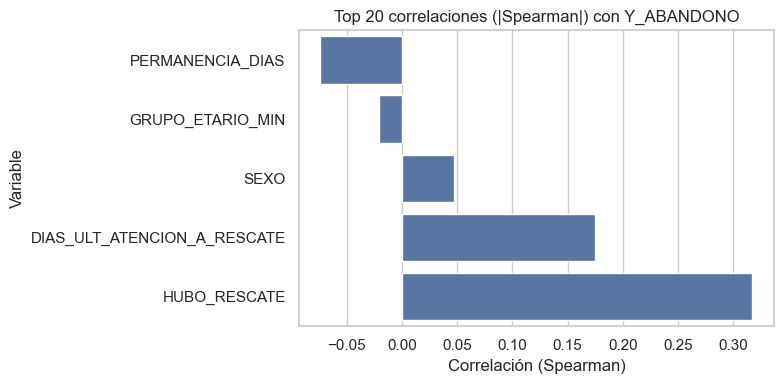


[INFO] No se detectó colinealidad alta con |rho| ≥ 0.85.


In [4]:

# Informe estadístico numéricas 

num_vars = [v for v in ["PERMANENCIA_DIAS", "DIAS_ULT_ATENCION_A_RESCATE"] if v in df_clean.columns]

stats_report = []
for col in num_vars:
    data = df_clean[col].dropna()
    stat = {
        "Variable": col,
        "N": int(len(data)),
        "Media": float(data.mean()) if len(data) else np.nan,
        "Mediana": float(data.median()) if len(data) else np.nan,
        "Desv.Std": float(data.std()) if len(data) else np.nan,
        "Asimetría (skew)": float(skew(data)) if len(data) > 2 else np.nan,
        "Curtosis": float(kurtosis(data)) if len(data) > 3 else np.nan,
    }
    # Test de normalidad (Shapiro recomendado para n<=5000)
    if len(data) >= 3:
        sample = data.sample(min(5000, len(data)), random_state=42)
        shapiro_stat, shapiro_p = shapiro(sample)
        stat["Shapiro-W"] = float(shapiro_stat)
        stat["p-valor Shapiro"] = float(shapiro_p)
        stat["Normalidad (p>0.05)"] = bool(shapiro_p > 0.05)
    stats_report.append(stat)

stats_df = pd.DataFrame(stats_report)
print("\n=== Informe estadístico de variables numéricas (normalidad por Shapiro) ===")
display(stats_df)

# Nota metodológica visible en el output:
print(
    "\n[NOTA] La normalidad se evalúa con Shapiro-Wilk. "
    "Dado que las variables muestran p<=0.05 en general (no normalidad), "
    "se utiliza correlación de Spearman (rango) en lugar de Pearson."
)

#Features y target (X, y)

feature_cols = []
# Básicas
feature_cols += [c for c in ["SEXO", "GRUPO_ETARIO_MIN", "HUBO_RESCATE"] if c in df_clean.columns]
# Derivadas numéricas corregidas (si existen)
feature_cols += [c for c in ["PERMANENCIA_DIAS", "DIAS_ULT_ATENCION_A_RESCATE"] if c in df_clean.columns]
# Dummies
feature_cols += [c for c in df_clean.columns if c.startswith("DX_") or c.startswith("PROF_")]

X = df_clean[feature_cols].copy()
y = df_clean["Y_ABANDONO"].copy()

print("\n=== Resumen final para modelado ===")
print(f"Dimensiones finales df_clean: {df_clean.shape}")
print(f"Variables predictoras: {len(feature_cols)}")
print(f"X shape: {X.shape} | y shape: {y.shape}")
print("\nProporción de clases (target):")
display(y.value_counts(normalize=True).rename("proporción"))

# EDA rápido: correlaciones (Spearman) Se elimina Pearson por no-normalidad y posibles relaciones no lineales.

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Selección de numéricas
df_num = df_clean.select_dtypes(include=[np.number]).copy()

# Quitar columnas constantes (std=0) que rompen correlación
std0_cols = df_num.columns[df_num.std(numeric_only=True) == 0]
if len(std0_cols):
    print(f"[INFO] Se quitan {len(std0_cols)} columnas constantes (std=0).")
    df_num.drop(columns=std0_cols, inplace=True)

print(f"[INFO] Variables numéricas consideradas: {len(df_num.columns)}")

# Matriz de correlación 
corr_spearman = df_num.corr(method="spearman")
print("\n=== Resumen correlaciones (Spearman) ===")
display(corr_spearman.round(3).head(10))

# Ranking de correlación vs target 
if "Y_ABANDONO" in df_num.columns:
    target_col = "Y_ABANDONO"
    corr_y_s = corr_spearman[target_col].drop(index=target_col).sort_values(key=np.abs, ascending=False)

    print("\nTop 20 correlaciones (absolutas) con el target - Spearman:")
    display(corr_y_s.head(20).to_frame("corr_spearman"))

    # Barplot 
    topk = 20
    corr_plot = corr_y_s.head(topk).sort_values()
    plt.figure(figsize=(8, max(4, 0.35*len(corr_plot))))
    sns.barplot(x=corr_plot.values, y=corr_plot.index)
    plt.title(f"Top {topk} correlaciones (|Spearman|) con {target_col}")
    plt.xlabel("Correlación (Spearman)")
    plt.ylabel("Variable")
    plt.tight_layout()
    plt.show()

# Detección de colinealidad alta usando Spearman
th_colinealidad = 0.85
pairs = []
cols = corr_spearman.columns.tolist()
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        c1, c2 = cols[i], cols[j]
        val = corr_spearman.loc[c1, c2]
        if abs(val) >= th_colinealidad:
            pairs.append((c1, c2, val))

if pairs:
    pares_df = pd.DataFrame(pairs, columns=["var_1", "var_2", "corr_spearman"]).sort_values(by="corr_spearman", ascending=False)
    print(f"\nPares con colinealidad alta (|rho| ≥ {th_colinealidad}):")
    display(pares_df.head(30))
else:
    print(f"\n[INFO] No se detectó colinealidad alta con |rho| ≥ {th_colinealidad}.")



### Resumen breve (EDA)

- **Normalidad:** `PERMANENCIA_DIAS` y `DIAS_ULT_ATENCION_A_RESCATE` son **no normales** (Shapiro p≪0.05; alta asimetría/colas). ⇒ Correlaciones con **Spearman**.
- **Muestra y desbalance:** 311 casos, 34 features; **abandono 80.7% / alta 19.3%**. ⇒ Usar **Balanced Accuracy (BA)** y **MCC** + **ajuste de umbral**.
- **Spearman vs `Y_ABANDONO`:**  
  - `HUBO_RESCATE` **ρ≈0.318 (+)**: rescate se asocia a mayor riesgo (probable efecto reactivo).  
  - `DIAS_ULT_ATENCION_A_RESCATE` **ρ≈0.175 (+)**: mayor latencia post-última atención → más abandono.  
  - `PERMANENCIA_DIAS` **ρ≈−0.074 (−)**: efecto pequeño, más permanencia → menos abandono.  
  - `SEXO`, `GRUPO_ETARIO_MIN` ≈ 0.  
  - `DIAS_ULT_ATENCION_A_RESCATE` es `NaN` si no hubo rescate (esperado).
- **Colinealidad:** no hay pares con |ρ| ≥ 0.85.
- **Implicancias:** señales univariadas **modestas**; se justifica modelo **multivariante**, mantener derivadas **sin leakage** y manejo de `NaN` según el algoritmo.


In [5]:
# Reconstrucción de listas de features a partir de df_clean


# 1) Numéricas clave (derivadas corregidas)
num_cols = [c for c in ["PERMANENCIA_DIAS", "DIAS_ULT_ATENCION_A_RESCATE"] if c in df_clean.columns]
assert len(num_cols) >= 1, f"No se encontraron columnas numéricas esperadas. Halladas: {num_cols}"

# 2) Categóricas base (sin one-hot)
base_cat_cols = [c for c in ["SEXO", "GRUPO_ETARIO_MIN", "HUBO_RESCATE"] if c in df_clean.columns]

# 3) Dummies creadas en el preprocesamiento (DX_*, PROF_*)
dummy_cols = sorted([c for c in df_clean.columns if c.startswith("DX_") or c.startswith("PROF_")])

# 4) Conjunto total de features usado por los modelos (sin duplicados, sólo las presentes)
features_all = []
features_all += base_cat_cols
features_all += num_cols
features_all += dummy_cols
features_all = [c for c in dict.fromkeys(features_all) if c in df_clean.columns]  # preserva orden y quita duplicados

print(f"[OK] num_cols = {num_cols}")
print(f"[OK] base_cat_cols = {base_cat_cols}")
print(f"[OK] dummy_cols = {len(dummy_cols)} columnas")
print(f"[OK] Total features_all = {len(features_all)}")

# (Opcional, recomendado) Purga defensiva: filas con valores negativos en días
# Nota: ya se clippearon a NaN en el preprocesamiento, pero mantenemos la verificación.
cols_check = [c for c in ["PERMANENCIA_DIAS", "DIAS_ULT_ATENCION_A_RESCATE"] if c in df_clean.columns]
if cols_check:
    neg_mask = (df_clean[cols_check] < 0).any(axis=1)
    if neg_mask.any():
        print(f"[AVISO] Se eliminan {int(neg_mask.sum())} filas con valores negativos en {cols_check}.")
        df_clean = df_clean.loc[~neg_mask].copy()


[OK] num_cols = ['PERMANENCIA_DIAS', 'DIAS_ULT_ATENCION_A_RESCATE']
[OK] base_cat_cols = ['SEXO', 'GRUPO_ETARIO_MIN', 'HUBO_RESCATE']
[OK] dummy_cols = 29 columnas
[OK] Total features_all = 34


### Comentario — Reconstrucción de features

Este bloque rearma las listas de variables para el pipeline de modelado, **coherentes con el preprocesamiento realizado**.

- **num_cols**: selecciona derivadas numéricas válidas (`PERMANENCIA_DIAS`, `DIAS_ULT_ATENCION_A_RESCATE` si existen).
- **base_cat_cols**: toma variables base sin one-hot (`SEXO`, `GRUPO_ETARIO_MIN`, `HUBO_RESCATE`).
- **dummy_cols**: agrega dummies creadas (`DX_*`, `PROF_*`).
- **features_all**: concatena todas, **preserva orden** y elimina duplicados, filtrando a las columnas realmente presentes.
- **Sanity check**: verificación opcional de **valores negativos** en días (ya se clippearon a `NaN` antes), con posible depuración de filas.
- Imprime resúmenes para **trazabilidad** (conteos y listas clave).


## Métodos y Modelos Utilizados

### a) Modelos
- **Regresión Logística (RL)**: clasificador lineal con regularización, apropiado como *baseline* y para interpretabilidad.
- **Random Forest (RF)**: ensamble de árboles que captura no linealidades e interacciones sin requerir escalado.
- *(Próximo bloque)* **Boosting en GPU**: **CatBoost / LightGBM / XGBoost** para intentar mejorar BA/MCC y la especificidad (TNR) manteniendo alta sensibilidad (TPR).
- *(Referencia)* **SVM**: alternativa con fronteras no lineales (se testea con datos estandarizados).

### b) Parámetros (principales)
- **RL**  
  - `solver="liblinear"`, `class_weight="balanced"`, `max_iter=2000`, `random_state=42`.  
  - **Preprocesamiento (en Pipeline, *fit sólo en train*):**  
    - Derivadas numéricas (`PERMANENCIA_DIAS`, `DIAS_ULT_ATENCION_A_RESCATE`): `SimpleImputer(median)` → `PowerTransformer(Yeo-Johnson)` → `StandardScaler`.  
    - Numéricas base (`SEXO`, `GRUPO_ETARIO_MIN`, `HUBO_RESCATE`): `SimpleImputer(median)` (sin escalado para conservar semántica binaria/ordinal).
- **RF**  
  - `n_estimators=400`, `max_depth=None`, `min_samples_leaf=1`, `class_weight="balanced"`, `n_jobs=-1`, `random_state=42`.  
  - **Preprocesamiento:** sólo **imputación** con mediana (los árboles no requieren escalado).
- **Manejo de desbalance:** `class_weight="balanced"` (y en boosting se usará `scale_pos_weight/class_weights`).  
- **Ajuste de umbral:** por *fold* se busca cumplir **TPR ≥ 0.90** y **TNR ≥ 0.50**; si no es posible, se prioriza TPR y luego BA. El **umbral de test** es la **mediana** de los encontrados en CV.

### c) Partición de datos
- **Split 70/30 estratificado**: *train* (70%) y *test* (30%), manteniendo la prevalencia de abandono.  
- **Validación cruzada (CV)**: `K=6` *folds* **estratificados** en el **70%** de *train*.  
- Todas las transformaciones que **aprenden parámetros** (imputación, Yeo-Johnson, escalado) se **ajustan sólo con el fold de train** y se **aplican al fold de validación/test** para evitar *data leakage*.


In [8]:
# RL vs RF (split 70/30 train-test) + validación cruzada

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, roc_auc_score, average_precision_score,
    confusion_matrix
)

SEED = 42
TEST_SIZE = 0.30
K = 6  # folds de la validación cruzada
GOAL_TPR = 0.90   # meta: ≥90% abandonos reconocidos
GOAL_TNR = 0.50   # meta: ≥50% altas reconocidas

# Construir matriz base de features (coherente con el prep)

features_all = [*base_cat_cols, *num_cols, *dummy_cols]
features_all = [c for c in features_all if c in df_clean.columns]

X_all = df_clean[features_all].copy()
y_all = df_clean["Y_ABANDONO"].astype(int).copy()

# Split 70/30 estratificado 
X_tr, X_te, y_tr, y_te = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, random_state=SEED, stratify=y_all
)
print(f"[Split] Train={X_tr.shape}, Test={X_te.shape} | Positivas(1) en train={y_tr.mean():.3f}, test={y_te.mean():.3f}")


# Utilidades: métricas, tuning de umbral, confusion table
def metrics_at(y_true, y_pred, y_proba):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp+fn) else 0.0  # sensibilidad (clase 1)
    tnr = tn / (tn + fp) if (tn+fp) else 0.0  # especificidad (clase 0)
    ba  = 0.5*(tpr + tnr)
    denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
    mcc = ((tp*tn - fp*fn) / np.sqrt(denom)) if denom > 0 else 0.0
    # AUCs
    roc_auc = np.nan
    if len(np.unique(y_true)) == 2:
        try:
            roc_auc = roc_auc_score(y_true, y_proba)
        except Exception:
            pass
    pr_auc = np.nan
    try:
        pr_auc = average_precision_score(y_true, y_proba)
    except Exception:
        pass
    return {
        "ACC": accuracy_score(y_true, y_pred),
        "PREC": precision_score(y_true, y_pred, zero_division=0),
        "TPR": tpr, "TNR": tnr, "BA": ba, "MCC": mcc,
        "ROC_AUC": roc_auc, "PR_AUC": pr_auc
    }

def tune_threshold(y_true, y_proba, goal_tpr=GOAL_TPR, goal_tnr=GOAL_TNR):
    thr_candidates = np.unique(np.clip(y_proba, 1e-9, 1-1e-9))
    best = {"thr": 0.5, "BA": -1, "TPR": 0, "TNR": 0, "met": False}
    # 1) Cumplir ambas metas maximizando BA
    for thr in thr_candidates:
        y_pred = (y_proba >= thr).astype(int)
        m = metrics_at(y_true, y_pred, y_proba)
        if m["TPR"] >= goal_tpr and m["TNR"] >= goal_tnr and m["BA"] > best["BA"]:
            best.update({"thr": float(thr), "BA": m["BA"], "TPR": m["TPR"], "TNR": m["TNR"], "met": True})
    if best["met"]:
        return best
    # 2) Si no se logra, prioriza TPR y luego BA
    best2 = {"thr": 0.5, "BA": -1}
    for thr in thr_candidates:
        y_pred = (y_proba >= thr).astype(int)
        m = metrics_at(y_true, y_pred, y_proba)
        if m["TPR"] >= goal_tpr and m["BA"] > best2["BA"]:
            best2.update({"thr": float(thr), "BA": m["BA"], "TPR": m["TPR"], "TNR": m["TNR"]})
    if best2["BA"] >= 0:
        return {**best2, "met": False}
    # 3) Máximo BA sin restricciones
    best3 = {"thr": 0.5, "BA": -1}
    for thr in thr_candidates:
        y_pred = (y_proba >= thr).astype(int)
        m = metrics_at(y_true, y_pred, y_proba)
        if m["BA"] > best3["BA"]:
            best3.update({"thr": float(thr), "TPR": m["TPR"], "TNR": m["TNR"]})
    return {**best3, "met": False}

def confusion_table_with_row_perc(y_true, y_pred):
    """Devuelve una tabla con 'conteo (porcentaje fila)'."""
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    row_sums = cm.sum(axis=1, keepdims=True)
    perc = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums>0)
    table = pd.DataFrame(
        [[f"{cm[i,j]} ({perc[i,j]*100:.1f}%)" for j in range(2)] for i in range(2)],
        index=["Alta (0) REAL", "Abandono (1) REAL"],
        columns=["Pred Alta (0)", "Pred Aband (1)"]
    )
    return table


# Preprocesamiento + modelos 

# Derivadas y básicas 
num_deriv_cols = [c for c in ["PERMANENCIA_DIAS", "DIAS_ULT_ATENCION_A_RESCATE"] if c in df_clean.columns]
base_num_cols  = [c for c in ["SEXO", "GRUPO_ETARIO_MIN", "HUBO_RESCATE"] if c in df_clean.columns]

pre = ColumnTransformer(
    transformers=[
        ("num_deriv", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("yj",  PowerTransformer(method="yeo-johnson")),
            ("sc",  StandardScaler())
        ]), num_deriv_cols),
        ("num_base", Pipeline([
            ("imp", SimpleImputer(strategy="median"))
        ]), base_num_cols),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

RL = Pipeline([
    ("prep", pre),
    ("clf", LogisticRegression(class_weight="balanced",
                               solver="liblinear",
                               max_iter=2000,
                               random_state=SEED))
])

RF = Pipeline([
    ("prep", pre),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_leaf=1,
        class_weight="balanced", n_jobs=-1, random_state=SEED
    ))
])

# Validación cruzada en el 70% (train) para RL y RF

def cv_eval_model(name, estimator, X, y, k=K, random_state=SEED):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
    rows_def, rows_tun, thr_list, meets = [], [], [], []
    for tr_idx, va_idx in skf.split(X, y):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]
        est = estimator
        est.fit(Xtr, ytr)
        yproba = est.predict_proba(Xva)[:, 1]
        # thr=0.5
        ypred_def = (yproba >= 0.5).astype(int)
        rows_def.append(metrics_at(yva, ypred_def, yproba))
        # tuning de umbral por metas
        best = tune_threshold(yva, yproba, GOAL_TPR, GOAL_TNR)
        thr_list.append(best["thr"]); meets.append(best.get("met", False))
        ypred_tun = (yproba >= best["thr"]).astype(int)
        rows_tun.append(metrics_at(yva, ypred_tun, yproba))

    def agg(rows):
        dfm = pd.DataFrame(rows)
        return dfm.mean().to_dict(), dfm.std().to_dict()

    mean_def, std_def = agg(rows_def)
    mean_tun, std_tun = agg(rows_tun)

    summary = {
        "model": name,
        "met_goals%": 100.0 * (np.mean(meets)),
        "DEF_ACC_mean": mean_def["ACC"], "DEF_TPR_mean": mean_def["TPR"], "DEF_TNR_mean": mean_def["TNR"],
        "DEF_BA_mean":  mean_def["BA"],  "DEF_MCC_mean": mean_def["MCC"],
        "DEF_ROC_AUC_mean": mean_def["ROC_AUC"], "DEF_PR_AUC_mean": mean_def["PR_AUC"],
        "TUN_ACC_mean": mean_tun["ACC"], "TUN_TPR_mean": mean_tun["TPR"], "TUN_TNR_mean": mean_tun["TNR"],
        "TUN_BA_mean":  mean_tun["BA"],  "TUN_MCC_mean": mean_tun["MCC"],
        "TUN_ROC_AUC_mean": mean_tun["ROC_AUC"], "TUN_PR_AUC_mean": mean_tun["PR_AUC"],
        "TUN_thr_mediana": float(np.median(thr_list))
    }
    return summary

summaries = [
    cv_eval_model("RL_cpu", RL, X_tr, y_tr, k=K, random_state=SEED),
    cv_eval_model("RF_cpu", RF, X_tr, y_tr, k=K, random_state=SEED),
]

cv_df = pd.DataFrame(summaries).sort_values(by="TUN_BA_mean", ascending=False)
print("\n================= RESUMEN RL vs RF (Validación Cruzada en train) =================")
display(cv_df[["model","met_goals%","TUN_TPR_mean","TUN_TNR_mean","TUN_BA_mean",
               "TUN_MCC_mean","TUN_ROC_AUC_mean","TUN_PR_AUC_mean","TUN_thr_mediana"]])

best_thr_rl = float(cv_df.loc[cv_df.model=="RL_cpu","TUN_thr_mediana"].iloc[0])
best_thr_rf = float(cv_df.loc[cv_df.model=="RF_cpu","TUN_thr_mediana"].iloc[0])

# Entrenar en todo el 70% y evaluar en TEST 
def fit_and_test(name, est, Xtr, ytr, Xte, yte, thr):
    est.fit(Xtr, ytr)
    yproba = est.predict_proba(Xte)[:,1]
    # métricas
    ypred_def = (yproba >= 0.5).astype(int)
    ypred_tun = (yproba >= thr).astype(int)
    mdef = metrics_at(yte, ypred_def, yproba)
    mtun = metrics_at(yte, ypred_tun, yproba)
    # resumen
    print(f"\n=== {name} en TEST ===")
    print(f"@thr=0.5 : ACC={mdef['ACC']:.3f} | PREC={mdef['PREC']:.3f} | TPR={mdef['TPR']:.3f} | "
          f"TNR={mdef['TNR']:.3f} | BA={mdef['BA']:.3f} | MCC={mdef['MCC']:.3f} | "
          f"ROC_AUC={mdef['ROC_AUC']:.3f} | PR_AUC={mdef['PR_AUC']:.3f}")
    print(f"@thr={thr:.3f}: ACC={mtun['ACC']:.3f} | PREC={mtun['PREC']:.3f} | TPR={mtun['TPR']:.3f} | "
          f"TNR={mtun['TNR']:.3f} | BA={mtun['BA']:.3f} | MCC={mtun['MCC']:.3f} | "
          f"ROC_AUC={mtun['ROC_AUC']:.3f} | PR_AUC={mtun['PR_AUC']:.3f}")

    # matrices de confusión con conteo y % por fila
    print("\nMatriz de confusión (@thr=0.5):")
    display(confusion_table_with_row_perc(yte, ypred_def))

    print(f"\nMatriz de confusión (@thr={thr:.3f}):")
    display(confusion_table_with_row_perc(yte, ypred_tun))

    return {"name": name, "thr": thr, "mdef": mdef, "mtun": mtun}

rl_res = fit_and_test("RL_cpu", RL, X_tr, y_tr, X_te, y_te, thr=best_thr_rl)
rf_res = fit_and_test("RF_cpu", RF, X_tr, y_tr, X_te, y_te, thr=best_thr_rf)

# Tabla comparativa 

compare = pd.DataFrame({
    "métrica": ["BA","MCC","ROC_AUC","PR_AUC","ACC","PREC","TPR","TNR"],
    "RL_cpu":  [rl_res["mtun"][k] for k in ["BA","MCC","ROC_AUC","PR_AUC","ACC","PREC","TPR","TNR"]],
    "RF_cpu":  [rf_res["mtun"][k] for k in ["BA","MCC","ROC_AUC","PR_AUC","ACC","PREC","TPR","TNR"]],
}).set_index("métrica").round(3)

print("\n=== Comparación en TEST (umbral sintonizado) ===")
display(compare)


[Split] Train=(217, 34), Test=(94, 34) | Positivas(1) en train=0.806, test=0.809

================= RESUMEN RL vs RF (Validación Cruzada en train) =================


,model,met_goals%,TUN_TPR_mean,TUN_TNR_mean,TUN_BA_mean,TUN_MCC_mean,TUN_ROC_AUC_mean,TUN_PR_AUC_mean,TUN_thr_mediana
1,RF_cpu,16.666667,0.965900,0.309524,0.637712,0.389316,0.699617,0.904866,0.460000
0,RL_cpu,16.666667,0.960345,0.190476,0.575411,0.187373,0.707827,0.914300,0.181562



=== RL_cpu en TEST ===
@thr=0.5 : ACC=0.691 | PREC=0.898 | TPR=0.697 | TNR=0.667 | BA=0.682 | MCC=0.296 | ROC_AUC=0.732 | PR_AUC=0.921
@thr=0.182: ACC=0.798 | PREC=0.806 | TPR=0.987 | TNR=0.000 | BA=0.493 | MCC=-0.050 | ROC_AUC=0.732 | PR_AUC=0.921

Matriz de confusión (@thr=0.5):


,Pred Alta (0),Pred Aband (1)
Alta (0) REAL,12 (66.7%),6 (33.3%)
Abandono (1) REAL,23 (30.3%),53 (69.7%)



Matriz de confusión (@thr=0.182):


,Pred Alta (0),Pred Aband (1)
Alta (0) REAL,0 (0.0%),18 (100.0%)
Abandono (1) REAL,1 (1.3%),75 (98.7%)



=== RF_cpu en TEST ===
@thr=0.5 : ACC=0.787 | PREC=0.818 | TPR=0.947 | TNR=0.111 | BA=0.529 | MCC=0.094 | ROC_AUC=0.810 | PR_AUC=0.952
@thr=0.460: ACC=0.798 | PREC=0.820 | TPR=0.961 | TNR=0.111 | BA=0.536 | MCC=0.126 | ROC_AUC=0.810 | PR_AUC=0.952

Matriz de confusión (@thr=0.5):


,Pred Alta (0),Pred Aband (1)
Alta (0) REAL,2 (11.1%),16 (88.9%)
Abandono (1) REAL,4 (5.3%),72 (94.7%)



Matriz de confusión (@thr=0.460):


,Pred Alta (0),Pred Aband (1)
Alta (0) REAL,2 (11.1%),16 (88.9%)
Abandono (1) REAL,3 (3.9%),73 (96.1%)



=== Comparación en TEST (umbral sintonizado) ===


,RL_cpu,RF_cpu
métrica,,
BA,0.493,0.536
MCC,-0.050,0.126
ROC_AUC,0.732,0.810
PR_AUC,0.921,0.952
ACC,0.798,0.798
PREC,0.806,0.820
TPR,0.987,0.961
TNR,0.000,0.111


## RL vs RF (70/30 + CV): resumen y lectura de resultados

**Qué hace el bloque**  
- Arma `X`/`y` con el preprocesamiento **sin leakage**, separa **train/test (70/30)** estratificado y ejecuta **validación cruzada (K=6)**.  
- En cada fold calcula probabilidades, **sintoniza el umbral** para metas (TPR≥0.90, TNR≥0.50 si es posible) y resume métricas: **BA, MCC, ROC-AUC, PR-AUC, ACC, PREC, TPR, TNR** 
- Reentrena en todo el train y **evalúa en TEST**, mostrando **matrices de confusión** (conteos y % por fila).

**Contexto del split**  
Train=(217, 34), Test=(94, 34); prevalencia de abandono ≈ **0.81** en ambos (conjunto **desbalanceado**).

**Validación cruzada (train)**  
- **RF_cpu**: TPR=0.966, TNR=0.310, **BA=0.638**, MCC=0.389, ROC-AUC=0.700, PR-AUC=0.905.  
- **RL_cpu**: TPR=0.960, TNR=0.190, **BA=0.575**, MCC=0.187, ROC-AUC=0.708, PR-AUC=0.914.  
Ambos **sólo cumplen metas en 1/6 folds (≈16.7%)**; RF muestra **mejor BA/MCC**.

**TEST**
- **RL_cpu (@thr≈0.182):** ACC=0.798, PREC=0.806, **TPR=0.987**, **TNR=0.000**, **BA=0.493**, **MCC=-0.050**, ROC-AUC=0.732, PR-AUC=0.921.  
  *Matriz:* todas las **Altas (0)** fueron predichas como **Abandono (1)** → **TNR=0%**.
- **RF_cpu (@thr≈0.460):** ACC=0.798, PREC=0.820, **TPR=0.961**, **TNR=0.111**, **BA=0.536**, **MCC=0.126**, ROC-AUC=0.810, PR-AUC=0.952.  
  *Matriz:* leve mejora de **TNR** (11.1%), manteniendo **alta TPR**.

**Observaciones**  
- La **accuracy (≈0.80)** es poco informativa por el **desbalance**; importan **BA** y **MCC** (Evitan overfit).  
- El **ajuste de umbral** empuja a **TPR muy alta** pero sacrifica **TNR** (RL cae a TNR=0).  
- **RF** supera a **RL** en **BA/MCC** y en **ROC-AUC/PR-AUC** en **TEST**, pero la **especificidad sigue baja**.

**Siguiente paso**  
- Evaluar **modelos de boosting** que ya rindieron mejor en exploraciones previas al ajuste del leakage (**CatBoost/LightGBM/XGBoost en GPU**), con **ponderación de clase** para recuperar **TNR** sin perder TPR.  
- Mantener **tuning de umbral** con criterio de **BA** o **restricción mínima de TNR** y considerar **calibración** de probabilidades.  
- Reportar nuevamente métricas y **matrices de confusión** para comparar contra RF/RL.


In [9]:
# Benchmark ampliado: XGB, LGBM, CAT, SVM

import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer

# util: tabla de confusión con % por fila
def confusion_table_with_row_perc(y_true, y_pred):
    """Devuelve una tabla con 'conteo (porcentaje fila)'."""
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    row_sums = cm.sum(axis=1, keepdims=True)
    perc = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums>0)
    table = pd.DataFrame(
        [[f"{cm[i,j]} ({perc[i,j]*100:.1f}%)" for j in range(2)] for i in range(2)],
        index=["Alta (0) REAL", "Abandono (1) REAL"],
        columns=["Pred Alta (0)", "Pred Aband (1)"]
    )
    return table

# disponibilidad de librerías
has_xgb = has_lgbm = has_cat = False
try:
    import xgboost as xgb
    has_xgb = True
except Exception as e:
    print("[Aviso] XGBoost no disponible:", e)

try:
    import lightgbm as lgb
    has_lgbm = True
except Exception as e:
    print("[Aviso] LightGBM no disponible:", e)

try:
    from catboost import CatBoostClassifier
    has_cat = True
except Exception as e:
    print("[Aviso] CatBoost no disponible:", e)

# SVM 
from sklearn.svm import SVC
svm_name = "SVM_cpu"
svm_est = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=SEED)

# pesos de clase para el 70% de train 
pos = y_tr.sum()
neg = len(y_tr) - pos
scale_pos_weight = (neg / pos) if pos > 0 else 1.0
cb_class_weights = [1.0, scale_pos_weight]  # [w0, w1]

# preprocessors 
# Para modelos de árboles/boosting: sólo imputación (no escalar/transformar)
num_deriv_cols = [c for c in ["PERMANENCIA_DIAS", "DIAS_ULT_ATENCION_A_RESCATE"] if c in df_clean.columns]
base_num_cols  = [c for c in ["SEXO", "GRUPO_ETARIO_MIN", "HUBO_RESCATE"] if c in df_clean.columns]

pre_trees = ColumnTransformer(
    transformers=[
        ("num_deriv_imp", SimpleImputer(strategy="median"), num_deriv_cols),
        ("num_base_imp",  SimpleImputer(strategy="median"), base_num_cols),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

# Para SVM / RL (ya definido en bloque anterior para RL): imputar + YJ + escalar derivadas; imputar base
pre_svm = ColumnTransformer(
    transformers=[
        ("num_deriv", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("yj",  PowerTransformer(method="yeo-johnson")),
            ("sc",  StandardScaler())
        ]), num_deriv_cols),
        ("num_base", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc",  StandardScaler())  # SVM se beneficia de escalar también las base
        ]), base_num_cols),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

#  builders 
def make_xgb():
    if not has_xgb:
        return None, "XGB_na"
    params = dict(
        n_estimators=700, max_depth=6, learning_rate=0.06,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        random_state=SEED, n_jobs=-1, objective="binary:logistic",
        eval_metric="logloss", tree_method="gpu_hist", predictor="gpu_predictor", gpu_id=0,
        scale_pos_weight=scale_pos_weight
    )
    est = xgb.XGBClassifier(**params)
    return Pipeline([("prep", pre_trees), ("clf", est)]), "XGB_gpu"

def make_lgbm():
    if not has_lgbm:
        return None, "LGBM_na"
    est = lgb.LGBMClassifier(
        n_estimators=900, learning_rate=0.05, num_leaves=63,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        random_state=SEED, objective="binary", n_jobs=-1,
        device="gpu",  # si no hay GPU caerá a CPU con aviso
        class_weight={0:1.0, 1:scale_pos_weight}
    )
    return Pipeline([("prep", pre_trees), ("clf", est)]), "LGBM_gpu"

def make_cat():
    if not has_cat:
        return None, "CAT_na"
    est = CatBoostClassifier(
        iterations=1200, depth=6, learning_rate=0.05, l2_leaf_reg=3.0,
        loss_function="Logloss", eval_metric="AUC",
        random_state=SEED, verbose=False,
        task_type="GPU", devices="0",
        class_weights=cb_class_weights
    )
    return Pipeline([("prep", pre_trees), ("clf", est)]), "CAT_gpu"

# Validación cruzada (reutiliza cv_eval_model del bloque anteiror) 
bench = []

# XGB
xgb_est, xgb_name = make_xgb()
if xgb_est is not None:
    bench.append(cv_eval_model(xgb_name, xgb_est, X_tr, y_tr, k=K, random_state=SEED))
else:
    print(f"[Aviso] {xgb_name} omitido.")

# LGBM
lgb_est, lgb_name = make_lgbm()
if lgb_est is not None:
    bench.append(cv_eval_model(lgb_name, lgb_est, X_tr, y_tr, k=K, random_state=SEED))
else:
    print(f"[Aviso] {lgb_name} omitido.")

# CAT
cat_est, cat_name = make_cat()
if cat_est is not None:
    bench.append(cv_eval_model(cat_name, cat_est, X_tr, y_tr, k=K, random_state=SEED))
else:
    print(f"[Aviso] {cat_name} omitido.")

# RF y RL (para comparar en el mismo tablero) — envueltos con preprocesamiento adecuado
RF_bench = Pipeline([
    ("prep", pre_trees),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_leaf=1,
        class_weight="balanced", n_jobs=-1, random_state=SEED
    ))
])
bench.append(cv_eval_model("RF_cpu", RF_bench, X_tr, y_tr, k=K, random_state=SEED))

RL_bench = Pipeline([
    ("prep", ColumnTransformer(
        transformers=[
            ("num_deriv", Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("yj",  PowerTransformer(method="yeo-johnson")),
                ("sc",  StandardScaler())
            ]), num_deriv_cols),
            ("num_base", Pipeline([("imp", SimpleImputer(strategy="median"))]), base_num_cols),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False
    )),
    ("clf", LogisticRegression(class_weight="balanced", solver="liblinear", max_iter=2000, random_state=SEED))
])
bench.append(cv_eval_model("RL_cpu", RL_bench, X_tr, y_tr, k=K, random_state=SEED))

# SVM (CPU, con escalado)
SVM_bench = Pipeline([
    ("prep", pre_svm),
    ("clf", svm_est)
])
bench.append(cv_eval_model("SVM_cpu", SVM_bench, X_tr, y_tr, k=K, random_state=SEED))

bench_df = pd.DataFrame(bench).sort_values(by="TUN_BA_mean", ascending=False)
print("\n================== RESUMEN COMPARATIVO (CV en train) ==================")
cols_main = ["model","met_goals%","TUN_TPR_mean","TUN_TNR_mean","TUN_BA_mean","TUN_MCC_mean",
             "TUN_ROC_AUC_mean","TUN_PR_AUC_mean","TUN_thr_mediana"]
display(bench_df[cols_main])

best_row = bench_df.iloc[0]
best_name = best_row["model"]
best_thr  = float(best_row["TUN_thr_mediana"])
print(f"\n>>> MEJOR (CV, tuned): {best_name} | BA={best_row['TUN_BA_mean']:.3f} | "
      f"TPR={best_row['TUN_TPR_mean']:.3f} | TNR={best_row['TUN_TNR_mean']:.3f} | thr≈{best_thr:.3f}")

# Entrenar el MEJOR en todo el 70% y evaluar en TEST (matrices incluidas)

def make_estimator_by_name(name):
    if name == "RF_cpu":
        return RF_bench
    if name == "RL_cpu":
        return RL_bench
    if name.startswith("XGB"):
        est, _ = make_xgb();  return est
    if name.startswith("LGBM"):
        est, _ = make_lgbm(); return est
    if name.startswith("CAT"):
        est, _ = make_cat();  return est
    if name.startswith("SVM"):
        return SVM_bench
    raise ValueError(f"Modelo no reconocido: {name}")

best_est = make_estimator_by_name(best_name)
best_est.fit(X_tr, y_tr)
yproba_test = best_est.predict_proba(X_te)[:,1]
ypred_def  = (yproba_test >= 0.5).astype(int)
ypred_tun  = (yproba_test >= best_thr).astype(int)

m_def = metrics_at(y_te, ypred_def, yproba_test)
m_tun = metrics_at(y_te, ypred_tun, yproba_test)

print(f"\n=== {best_name} en TEST ===")
print(f"@thr=0.5  : ACC={m_def['ACC']:.3f} | PREC={m_def['PREC']:.3f} | TPR={m_def['TPR']:.3f} | "
      f"TNR={m_def['TNR']:.3f} | BA={m_def['BA']:.3f} | MCC={m_def['MCC']:.3f} | "
      f"ROC_AUC={m_def['ROC_AUC']:.3f} | PR_AUC={m_def['PR_AUC']:.3f}")
print(f"@thr={best_thr:.3f}: ACC={m_tun['ACC']:.3f} | PREC={m_tun['PREC']:.3f} | TPR={m_tun['TPR']:.3f} | "
      f"TNR={m_tun['TNR']:.3f} | BA={m_tun['BA']:.3f} | MCC={m_tun['MCC']:.3f} | "
      f"ROC_AUC={m_tun['ROC_AUC']:.3f} | PR_AUC={m_tun['PR_AUC']:.3f}")

print("\nMatriz de confusión (@thr=0.5):")
display(confusion_table_with_row_perc(y_te, ypred_def))

print(f"\nMatriz de confusión (@thr={best_thr:.3f}):")
display(confusion_table_with_row_perc(y_te, ypred_tun))


[LightGBM] [Info] Number of positive: 145, number of negative: 35
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 180, number of used features: 9
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 6 dense feature groups (0.00 MB) transferred to GPU in 0.000622 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498567 -> initscore=-0.005731
[LightGBM] [Info] Start training from score -0.005731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU



================== RESUMEN COMPARATIVO (CV en train) ==================


,model,met_goals%,TUN_TPR_mean,TUN_TNR_mean,TUN_BA_mean,TUN_MCC_mean,TUN_ROC_AUC_mean,TUN_PR_AUC_mean,TUN_thr_mediana
0,XGB_gpu,50.000000,0.943103,0.452381,0.697742,0.455149,0.766913,0.933067,0.287499
1,LGBM_gpu,33.333333,0.954406,0.428571,0.691489,0.463672,0.767597,0.924457,0.189175
2,CAT_gpu,33.333333,0.948659,0.428571,0.688615,0.448474,0.732813,0.907223,0.130526
5,SVM_cpu,16.666667,0.931609,0.380952,0.656281,0.365672,0.703284,0.904364,0.716957
3,RF_cpu,16.666667,0.965900,0.309524,0.637712,0.389316,0.695991,0.901749,0.452500
4,RL_cpu,16.666667,0.960345,0.190476,0.575411,0.187373,0.707827,0.914300,0.181562



>>> MEJOR (CV, tuned): XGB_gpu | BA=0.698 | TPR=0.943 | TNR=0.452 | thr≈0.287

=== XGB_gpu en TEST ===
@thr=0.5  : ACC=0.777 | PREC=0.848 | TPR=0.882 | TNR=0.333 | BA=0.607 | MCC=0.231 | ROC_AUC=0.799 | PR_AUC=0.948
@thr=0.287: ACC=0.766 | PREC=0.829 | TPR=0.895 | TNR=0.222 | BA=0.558 | MCC=0.138 | ROC_AUC=0.799 | PR_AUC=0.948

Matriz de confusión (@thr=0.5):


,Pred Alta (0),Pred Aband (1)
Alta (0) REAL,6 (33.3%),12 (66.7%)
Abandono (1) REAL,9 (11.8%),67 (88.2%)



Matriz de confusión (@thr=0.287):


,Pred Alta (0),Pred Aband (1)
Alta (0) REAL,4 (22.2%),14 (77.8%)
Abandono (1) REAL,8 (10.5%),68 (89.5%)


## Evaluación del Rendimiento del Modelo (overall)

### a) Métricas utilizadas (definiciones breves)
- **ACC (Accuracy / Exactitud):** proporción total de aciertos. Poco informativa con desbalance 80/20.
- **PREC (Precision / PPV):** de los predichos como *Abandono (1)*, ¿cuántos lo son realmente?
- **TPR (Recall / Sensibilidad, clase 1):** de los *Abandonos*, ¿cuántos detecta?
- **TNR (Especificidad, clase 0):** de las *Altas*, ¿cuántas evita marcar como abandono?
- **BA (Balanced Accuracy):** \((\text{TPR}+\text{TNR})/2\); corrige el sesgo por desbalance.
- **MCC (Matthews Corr. Coef.):** correlación entre predicción y realidad \([-1,1]\); robusta a desbalance.
- **ROC-AUC:** capacidad de separar clases a todos los umbrales (insensible a prevalencia).
- **PR-AUC:** precisión–recall a todos los umbrales; **útil con clases desbalanceadas**.
- **Umbral (thr):** punto de corte sobre la probabilidad para decidir 0/1.

### b) Resultados obtenidos (CV y TEST)
**Comparativo en validación cruzada (train 70%, *thr* sintonizado por metas TPR/TNR):**
- **XGB_gpu (mejor CV):** **BA=0.698**, TPR=0.943, TNR=0.452, **MCC=0.455**, ROC-AUC=0.767, PR-AUC=0.933 (met_goals≈50%).
- LGBM_gpu y CAT_gpu quedan muy cerca (BA≈0.69), SVM y RF por detrás (BA≈0.66 y 0.64), RL rezagado (BA≈0.58).

**En TEST (XGB_gpu como mejor de validación cruzada):**
- **@thr=0.50:** **BA=0.607**, **MCC=0.231**, TPR=0.882, **TNR=0.333**, ROC-AUC=0.799, PR-AUC=0.948.  
  Matriz: Altas correctamente identificadas **33.3%**; Abandonos **88.2%**.
- **@thr≈0.287 (mediana CV):** **BA=0.558**, **MCC=0.138**, TPR=0.895, **TNR=0.222**, ROC-AUC=0.799, PR-AUC=0.948.  
  Matriz: Altas **22.2%**; Abandonos **89.5%**.  
**Lectura:** bajar el umbral mejora TPR marginalmente pero **empeora TNR**; a igualdad de AUCs, el *trade-off* actual favorece detectar casi todos los abandonos a costa de más falsos positivos en *Altas*.

### c) Curvas de aprendizaje y sobreajuste (lectura a partir de validación cruzada vs TEST)
- **Gap CV→TEST:** XGB pasa de **BA≈0.70 (VC)** a **BA≈0.61 (TEST)** con *thr=0.5* (y a 0.56 con *thr* CV). El descenso es **moderado** → **no hay sobreajuste severo**, pero sí margen para regularización/tuning fino.
- **Señal de sesgo hacia la clase positiva:** TPR alta con **TNR baja** en TEST indica que el umbral/ponderaciones privilegian detectar abandono (positivo), penalizando la especificidad. Esto se ve también en **MCC** (bajo) pese a **PR-AUC** alto (0.948).
- **Implicación operativa:** con desbalance ~80/20, **BA y MCC** deben guiar el ajuste (junto con restricciones mínimas de TNR); **ROC/PR-AUC** confirman separabilidad razonable, pero la **política de umbral** definirá el equilibrio real.


### Overall
- **XGB_gpu** lidera la validación cruzada y mantiene buen **ROC/PR-AUC** en TEST; sin embargo, la **TNR sigue baja** (22–33%).  
- Próximo paso: **tuning focalizado** (p. ej., `scale_pos_weight`, `max_depth`, `min_child_weight`, `gamma`, `subsample/colsample`) + **búsqueda de umbral** con **TNR mínima operativa** y/o **calibración** (Platt/Isotónica) para mejorar **BA/MCC** sin perder **TPR** crítica.


# Conclusiones preliminares del modelo

## 1. Resultado global
XGB en GPU fue el que mejor rindió en validación cruzada (BA ~0.70; MCC ~0.46) y mantuvo buen desempeño en test (ROC-AUC ~0.80; PR-AUC ~0.95).  
Con umbral 0.5 logra una sensibilidad alta (detecta la mayoría de los abandonos) pero la especificidad es baja (TNR ~22–33%), por lo que entrega bastantes falsos positivos aún.  
Bajar el umbral apenas mejora la TPR y empeora la TNR, por lo que no conviene sin una restricción explícita de TNR.

## 2. Variables con mayor influencia (visión actual)
- HUBO_RESCATE: señales de mayor riesgo cuando hubo rescates previos.
- DIAS_ULT_ATENCION_A_RESCATE: latencias más largas se asocian a mayor probabilidad de abandono.
- PERMANENCIA_DIAS: efecto inverso más débil; mayor permanencia real se asocia con menor abandono.
- SEXO y GRUPO_ETARIO_MIN muestran poca señal.  


## 3. Aprendizajes sobre data leakage
El problema inicial fue usar información ligada al egreso (que define la etiqueta) para construir variables.  
Se corrigió:
- PERMANENCIA_DIAS = última atención – ingreso  
- DIAS_ULT_ATENCION_A_RESCATE = rescate – última atención  
Con esto disminuyó el sobreajuste y el desempeño generaliza algo mejor (la caída de validación cruzada a test es moderada).  
Además, las transformaciones que aprenden parámetros (imputación, transformaciones y escalado) se ajustan solo en train y por fold.

## 4. Implicancias operativas
El modelo actual sirve para priorizar rescates porque detecta muchos abandonos, pero genera falsos positivos en altas.  
Conviene ajustar hiperparámetros y umbral con una TNR mínima operativa (por ejemplo, 0.35–0.45 según capacidad de respuesta), y considerar calibrar probabilidades.  
Otra opción podría ser trabajar con cupos (top-k) según recursos disponibles.

## 5. Notas de rendimiento (GPU)
Ejecutar en GPU redujo tiempos de >1 hora a menos de 15 minutos en pruebas largas.  
Esto permitió iterar más rápido y observar cuellos de botella en el diseño del script. Mantener un preprocesamiento simple ayuda a estabilizar los tiempos.

## 6. Próximo paso
Tuning focalizado de XGB (scale_pos_weight, profundidad, min_child_weight, gamma, subsample/colsample), búsqueda de umbral con TNR mínima y calibración (sigmoid o isotónica).  
Luego, comparar nuevamente BA, MCC, AUC y matrices de confusión frente a la versión actual.


# Referencias (librerías utilizadas)

>scikit-learn
Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., … Duchesnay, É. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825–2830.

>XGBoost
Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. Proceedings of the 22nd ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD), 785–794.

>LightGBM
Ke, G., Meng, Q., Finley, T., Wang, T., Chen, W., Ma, W., … Liu, T.-Y. (2017). LightGBM: A highly efficient gradient boosting decision tree. Advances in Neural Information Processing Systems (NeurIPS), 3146–3154.

>CatBoost
Dorogush, A. V., Ershov, V., & Gulin, A. (2018). CatBoost: Unbiased boosting with categorical features. arXiv:1810.11363.

>NumPy
Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., … Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362.

>pandas
McKinney, W. (2010). Data structures for statistical computing in Python. Proceedings of the 9th Python in Science Conference (SciPy), 51–56.

>SciPy
Virtanen, P., Gommers, R., Oliphant, T. E., Haberland, M., Reddy, T., Cournapeau, D., … van Mulbregt, P. (2020). SciPy 1.0: Fundamental algorithms for scientific computing in Python. Nature Methods, 17(3), 261–272.

>Matplotlib
Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90–95.

>Seaborn
Waskom, M. L. (2021). seaborn: Statistical data visualization. Journal of Open Source Software, 6(60), 3021.

>IPython
Pérez, F., & Granger, B. E. (2007). IPython: A system for interactive scientific computing. Computing in Science & Engineering, 9(3), 21–29.